In [1]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM, SSMCMain.ModifiedMiCRM.RandomSystems

In [2]:
using Base.Threads, OhMyThreads
using BenchmarkTools
using JLD2
using Geppetto
using EnumX
using Random, Distributions
using FreqTables
using Graphs

In [3]:
using CairoMakie
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

# Setup

In [4]:
import Base: copy

struct LinstabScanTester_SAR{F}
    ks::Vector{F}
    M1::Matrix{F}
    M::Matrix{F}
    threshold::F
    function LinstabScanTester_SAR(ks, N, threshold=2 * eps())
        M1 = Matrix{eltype(ks)}(undef, N, N)
        M = Matrix{eltype(ks)}(undef, N, N)
        new{eltype(ks)}(ks, M1, M, threshold)
    end
end
function LinstabScanTester_SAR(ks, p::AbstractMMiCRMParams, threshold=2 * eps())
    LinstabScanTester(ks, sum(get_Ns(p)), threshold)
end
function (lt::LinstabScanTester_SAR)(sp::AbstractSMMiCRMParams, ss)
    make_M1!(lt.M1, sp, ss)

    evals = eigvals(lt.M1)
    if any(l -> real(l) > 0., evals)
        return -1
    end

    for k in lt.ks
        lt.M .= lt.M1
        M1_to_M!(lt.M, get_Ds(sp), k)
        evals = eigvals!(lt.M)
        if any(l -> real(l) > lt.threshold, evals)
            return 1
        end
    end
    return 2
end
function copy(lst::LinstabScanTester_SAR)
    LinstabScanTester_SAR(lst.ks, size(lst.M)[1], lst.threshold)
end

copy (generic function with 469 methods)

In [5]:
# can add a copy of example_do_rg_run if we need more flexibility
function do_rg_run(rg, num_repeats, ks;
    extinctthreshold=1e-8,
    maxresidthreshold=1e-9,
    linstabthreshold=100 * eps(),
    return_interesting=false
)
    @time "Generating one params" sample_params = rg()
    flush(stdout)
    Ns, Nr = get_Ns(sample_params)
    N = Ns + Nr

    # prep for the run
    lst = LinstabScanTester_SAR(ks, N, linstabthreshold)

    rslts = fill(0, num_repeats)
    interesting_systems = []

    @tasks for i in 1:num_repeats
        @local llst = copy(lst)

        params = rg()

        result = 0
        interesting = false

        # numerically solve for the steady state
        u0 = ModifiedMiCRM.make_u0_onlyN(params)
        ssp = make_mmicrm_ss_problem(params, u0)
        ssps = solve(ssp, DynamicSS(QNDF());
            reltol=maxresidthreshold,
            #isoutofdomain=(u,_,_)-> any(x -> x < 0., u),
            maxiters=1000000
        )

        if SciMLBase.successful_retcode(ssps.retcode)
            warning = false
            maxresid = maximum(abs, ssps.resid)
            if maxresid > maxresidthreshold * 100
                @warn (@sprintf "maxresid reached is %g which is close to %g" maxresid (maxresidthreshold * 100))
                warning = true
            end

            if all(x -> abs(x) < extinctthreshold, ssps.u[1:Ns])
                result = -101 # gone extinct in nospace ss
            end

            linstab_result = llst(params, ssps.u)
            if !warning
                if linstab_result == 1
                    result = 2 # spatial instability
                    interesting = true
                elseif linstab_result == 2
                    result = 1 # stable
                else
                    result = 3 # stable but may be wrong
                end
            else
                if linstab_result == 1
                    result = -2 # spatial instability but may be wrong
                elseif linstab_result == 2
                    result = -1 # stable but may be wrong
                else
                    result = -3 # stable but may be wrong
                end
            end
        else
            result = -100
        end

        rslts[i] = result
        if return_interesting && interesting
            push!(interesting_systems, params)
        end

        # @printf "Run %d -> %d\n" i rslts[i]
        # flush(stdout)
    end

    if !return_interesting
        rslts
    else
        rslts, interesting_systems
    end
end

do_rg_run (generic function with 1 method)

## Looking at the tendencies of unstable communities

In [6]:
function trim_abundnaces(abundances)
    # we will keep only those abundnaces over a certain threshold
    threshold = 1e-6
    
    return [a for a in abundances if a > threshold]
end


trim_abundnaces (generic function with 1 method)

In [7]:
function shannon_entropy(abundances)
    # Shannon entropy
    n = sum(abundances)
    -sum((f / n) * log2(f / n) for f in abundances if f > 0)
end

shannon_entropy (generic function with 1 method)

In [8]:
function BP_dominance(abundances)
    # BP dominance
    n = sum(abundances)
    maximum(abundances) / n
end

BP_dominance (generic function with 1 method)

In [9]:
dat = [0.1,0.1,0.2,0.2,0.4]
println(shannon_entropy(dat))
println(BP_dominance(dat))

2.1219280948873624
0.4


In [10]:
function do_rg_run2(rg, num_repeats, kmax, Nks;
    maxresidthr=1e-7,            # will warn if ss residues are larger than this
    errmaxresidthr=1e6 * maxresidthr, # if above this will return error code
    extinctthr=maxresidthr / 10, # species below this value are considered extinct
    lszerothr=100 * eps(),      # values +- this are considered 0 in linstab analysis
    lspeakthr=lszerothr,
    # whether and which params to return for further examination (int <-> interesting)
    return_int=nothing,
    return_int_sss=true,
    # ss solver setup
    ode_solver=Rodas4(),
    tol=maxresidthr / 10,
    timelimit=nothing, # time limit for one solver run in seconds
    abstol=tol,
    reltol=tol,
    maxiters=100000,
    # passed to make_mmicrm_ss_problem
    kwargs...
)
    sample_params = rg()
    Ns, Nr = get_Ns(sample_params)
    N = Ns + Nr

    # handle interesting systems setup
    int_func = if isnothing(return_int)
        nothing
    elseif isa(return_int, Vector) || isa(return_int, Tuple)
        c -> c in return_int
    elseif isa(return_int, Function)
        return_int
    elseif return_int == :all
        c -> true
    else
        throw(ArgumentError("return_interesting needs to be either a list of codes or a custom function"))
    end

    solver_kwargs = (; maxiters, abstol, reltol)
    if !isnothing(timelimit)
        solver_kwargs = (; solver_kwargs..., callback=make_timer_callback(timelimit))
    end

    # setup ks for linstab analysis
    ks = LinRange(0.0, kmax, Nks)[2:end] # 0 is handled separately

    # setup the returned data containers
    rslts = fill(0, num_repeats)

    # these may not be used, skipping the if to not have them boxed
    int_lock = ReentrantLock()
    int_systems_to_return = typeof(sample_params)[]
    int_systems_sss = Vector{Float64}[]

    # the core of the function
    @localize solver_kwargs @tasks for i in 1:num_repeats
        # Prealloc variables in each thread (task)
        @local begin
            M1 = Matrix{Float64}(undef, N, N)
            M = Matrix{Float64}(undef, N, N)
            mrls = Vector{Float64}(undef, length(ks))
        end

        # Setup one random system
        params = rg()
        u0 = ModifiedMiCRM.make_u0_onlyN(params)
        ssp = make_mmicrm_ss_problem(params, u0; kwargs...)
        result = 0
        warning = false

        ######################################## 

        # numerically solve for the steady state
        ssps = solve(ssp, DynamicSS(ode_solver);
            isoutofdomain=(u,_,_)-> any(x -> x < 0., u), solver_kwargs...)

        # Check the solver
        if !SciMLBase.successful_retcode(ssps.retcode)
            result = -1000 # solver failed return code
            result -= Int(ssps.original.retcode)
            if ssps.original.retcode == ReturnCode.MaxTime
                @warn "Solver quit due to time limit being reached"
                flush(stderr)
            end
            @goto handle_result
        end
        # Check that the steady state is steady enough
        maxresid = maximum(abs, ssps.resid)
        if maxresid > errmaxresidthr
            @warn (@sprintf "maxresid reached is %g which is above the error threshold of %g" maxresid maxresidthr)
            result = -2000 # maxresid is way beyond any reasonable values
            @goto handle_result
        elseif maxresid > maxresidthr
            @warn (@sprintf "maxresid reached is %g > %g" maxresid maxresidthr)
            warning = true
        end

        # Check for a full extinction
        if all(x -> abs(x) < extinctthr, ssps.u[1:Ns])
            result = 101 # gone extinct in nospace ss
            @goto handle_result
        end

        # Do linear stability

        # handle the k=0 case
        make_M1!(M1, params, ssps.u)
        k0mrl = maximum(real, eigvals!(M1))

        # calculate mrls
        make_M1!(M1, params, ssps.u)
        for (ki, k) in enumerate(ks)
            M .= M1
            M1_to_M!(M, get_Ds(params), k)
            evals = eigvals!(M)
            mrls[ki] = maximum(real, evals)
        end

        # evaluate the mrl results
        maxmrl, maxi = findmax(mrls)

        if k0mrl < -lszerothr # this is the ideal case
            if maxmrl < -lspeakthr
                result = 1
                @goto handle_result
            else
                result = 2
                @goto handle_result
            end
        elseif k0mrl < lszerothr # this can happen when there are interchangeable species, or when close to numerical issues
            if maxmrl < -lspeakthr
                result = 11
                @goto handle_result
            else
                is_separated = false
                for intermediate_mrl in mrls[1:maxi]
                    if intermediate_mrl < -lszerothr
                        is_separated = true
                        break
                    end
                end
                if is_separated # k0 is sketchy but we have a separated positive peak
                    result = 12
                    @goto handle_result
                else # the largest peak is connected to a positive k0 - clearly messy
                    result = 13
                    @goto handle_result
                end
            end
        else # something is definitely off here, however still do the same analysis for extra info
            if maxmrl < lspeakthr
                result = 21
                @goto handle_result
            else
                is_separated = false
                for intermediate_mrl in mrls[1:maxi]
                    if intermediate_mrl < -lszerothr
                        is_separated = true
                        break
                    end
                end
                if is_separated
                    result = 22
                    @goto handle_result
                else
                    result = 23
                    @goto handle_result
                end
            end
        end

        ######################################## 

        @label handle_result
        if warning
            result *= -1
        end
        rslts[i] = result
        if !isnothing(int_func) && int_func(result)
            lock(int_lock) do
                push!(int_systems_to_return, params)
                if return_int_sss
                    push!(int_systems_sss, ssps.u)
                end
            end
        end
    end

    if isnothing(int_func)
        rslts
    else
        if !return_int_sss
            rslts, int_systems_to_return
        else
            rslts, int_systems_to_return, int_systems_sss
        end
    end
end


do_rg_run2 (generic function with 1 method)

In [11]:
nthreads()

6

In [12]:
function sigma_to_mu_ratio1()
    (2 / 3) / 2.355
end


sigma_to_mu_ratio1 (generic function with 1 method)

In [13]:
function func(N, R, lm, lc, ll, lsi, lsr, lsb,Ds=1e-10, Dr=1)
        total_influx = 1.0 * R # setting E (or E/V)
        Kmean = total_influx / (lsi * R)
        K = (Kmean, Kmean * sigma_to_mu_ratio1())

        RSGJans1(N, R;
            m=(lm, lm * sigma_to_mu_ratio1()),
            r=1.0, # setting T
            sparsity_influx=lsi,
            K,
            sparsity_resources=lsr,
            sparsity_byproducts=lsb,
            c=(lc, lc * sigma_to_mu_ratio1()),
            l=(ll, ll * sigma_to_mu_ratio1()),
            Ds, Dr # diffusions passed through
        )
end

func (generic function with 3 methods)

In [14]:
N = R = 20
retain = (2, 1) # interesting results to return

rsg = func(N,R,0.2, 2, 0.9, 0.1, 0.3, 0.3)

xx,prms,sses = do_rg_run2(rsg, 100, 50,1000;
    maxresidthr=1e-8,
    tol=1e-11,
    return_int=retain
)

freqtable(xx)

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/stevenredford/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/stevenredford/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589


3-element Named Vector{Int64}
Dim1  │ 
──────┼───
-1004 │  2
1     │ 94
2     │  4

In [15]:
# print shape of outputs
println("Results shape: ", size(xx))
println("Params shape: ", size(prms))
println("SS shape: ", size(sses))

Results shape: (100,)
Params shape: (98,)
SS shape: (98,)


In [16]:
# plotting diversity for all of the interesting systems
using GLMakie 
GLMakie.activate!()

shannon_entropies = Float64[]
bp_dominances = Float64[]
n_strains = Int[]  # Store the actual codes that we kept

# Only process systems that match our retain codes
for (code, ss) in zip(xx, sses)
    extant_strains = trim_abundnaces(ss[1:N])
    push!(n_strains, length(extant_strains))
    push!(shannon_entropies, shannon_entropy(extant_strains))
    push!(bp_dominances, BP_dominance(extant_strains))

end

# Filter the results to only include those with codes in retain
retain_set = Set(retain)
xx_retained = filter(code -> code in retain_set, xx)

# Create color array based on retained codes
colors = map(code -> code == 1 ? (:gray, 0.3) : code == 2 ? :red : code == 21 ? :blue : :gray, 
            filter(code -> code in retain, xx))

# Scatterplot of Shannon Entropy vs BP Dominance
fig = Figure()
ax = Axis(fig[1, 1], title="Diversity of HSS vs Stability",
    xlabel="Shannon Entropy", ylabel="BP Dominance")
scatter!(ax, shannon_entropies, bp_dominances, markersize=20, color=colors)

display(GLMakie.Screen(),fig)


# scatterplot Shannon entropy vs number of strains
fig2 = Figure()
ax2 = Axis(fig2[1, 1], title="Number of Strains and Shannon Diversity in HSS",
    xlabel="Number of Strains", ylabel="Shannon Entropy")
scatter!(ax2, n_strains, shannon_entropies, markersize=20, color=colors)
display(fig2)
#fig2


GLMakie.Screen(...)

In [17]:
# plot the interaction graphs for the unstable systems

# get number of unstable systems
n_unstable = count(code -> code == 2, xx)
println("Number of unstable systems: ", n_unstable)

# get the indices of unstable systems
unstable_indices = findall(code -> code == 2, xx)

println("Indices of unstable systems: ", unstable_indices)

# plot the interaction graphs for the unstable systems
for idx in 1:2
    ss = sses[idx]
    params = prms[idx]
    println("Plotting interaction graph for unstable system at index: ", idx)
    
    # create the interaction graph
    g = diagram_sfss_v3(params, ss;
        cluster=true
    )

    # plot the interaction graph
    display(GLMakie.Screen(), g, 
        )
end

Number of unstable systems: 4
Indices of unstable systems: [46, 82, 87, 88]
Plotting interaction graph for unstable system at index: 1


MethodError: MethodError: no method matching display(::GLMakie.Screen{GLFW.Window}, ::GraphvizDotLang.Graph)
The function `display` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  display(!Matched::VSCodeServer.JuliaNotebookInlineDisplay, ::Any)
   @ VSCodeServer ~/.vscode/extensions/julialang.language-julia-1.146.2/scripts/packages/VSCodeServer/src/notebookdisplay.jl:31
  display(!Matched::VSCodeServer.InlineDisplay, ::Any)
   @ VSCodeServer ~/.vscode/extensions/julialang.language-julia-1.146.2/scripts/packages/VSCodeServer/src/display.jl:197
  display(!Matched::TextDisplay, ::Any)
   @ Base multimedia.jl:255
  ...


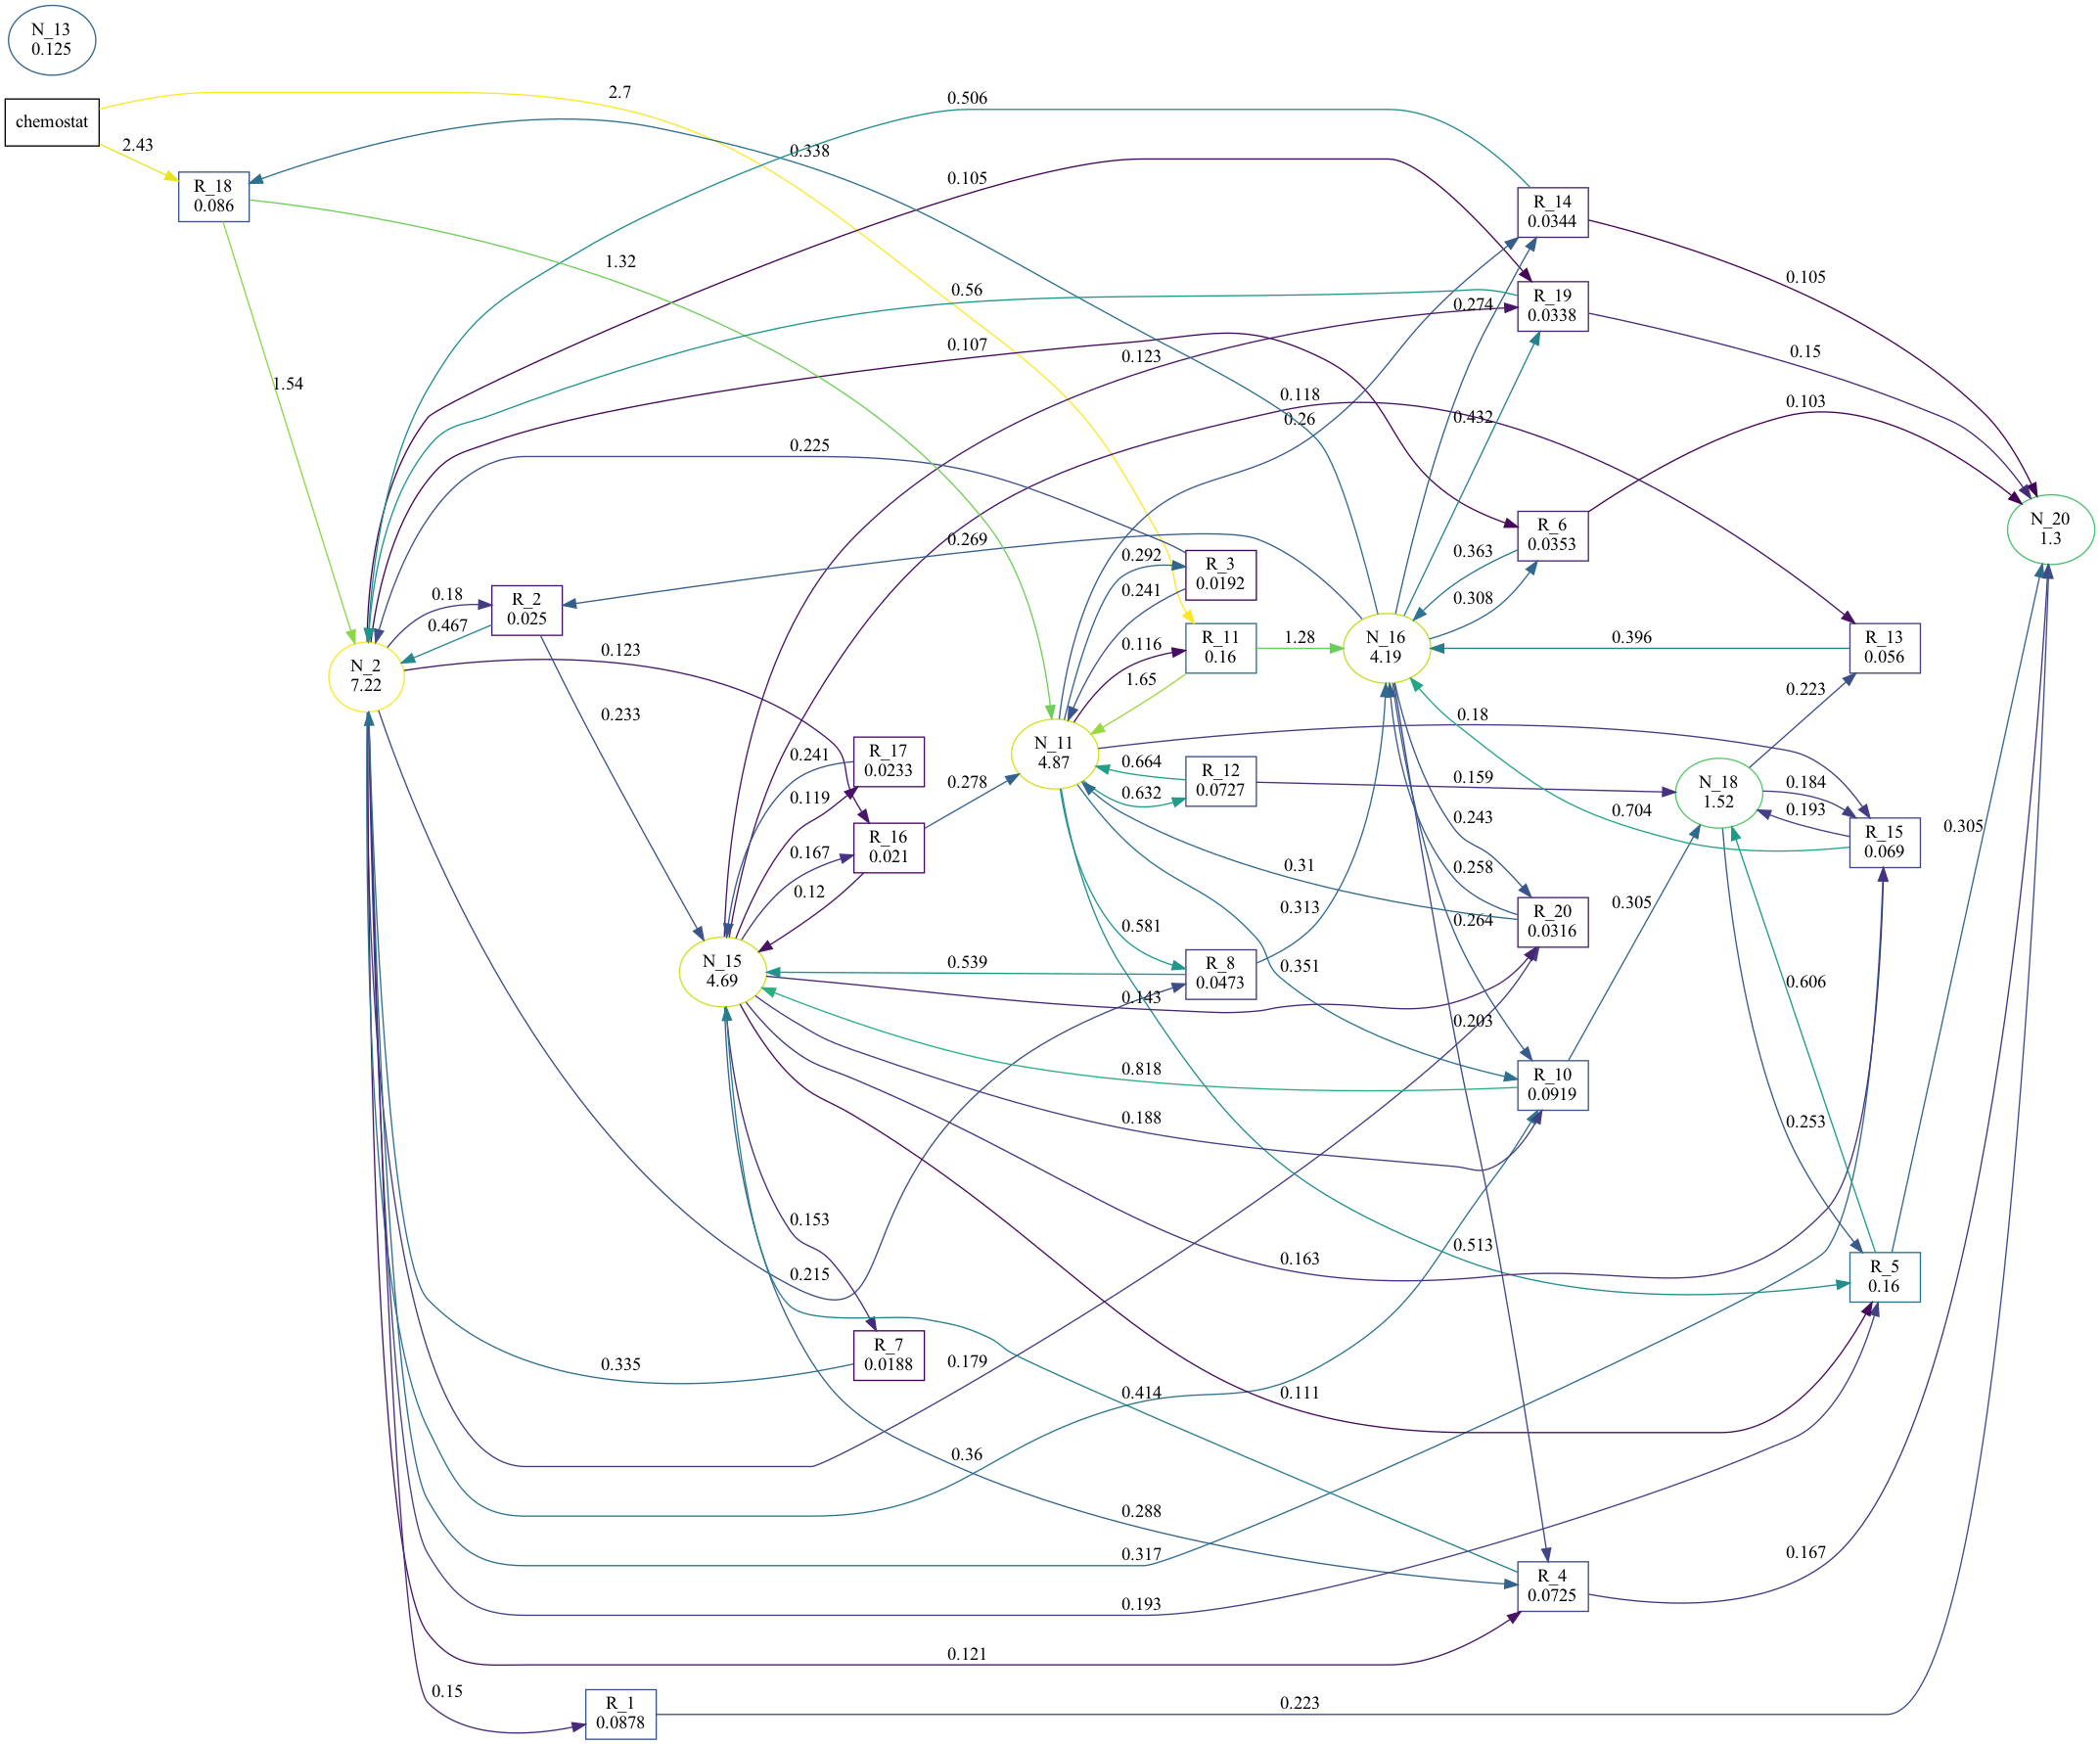

In [26]:
trm_p = prms[1]
trm_ss = sses[1]

g = diagram_sfss_v3(trm_p, trm_ss;
        strain_threshold=0.1,
        edge_threshold=0.1,
        #cluster=true
    )

In [25]:
using GraphvizDotLang
GraphvizDotLang.save(g, "interaction_graph.svg")

## Analyzing the biomass changes in unstable communities

In [18]:
N = R = 20
retain = (2,) # interesting results to return

rsg = func(N,R,0.2, 2, 0.9, 0.1, 0.3, 0.3)

xx,prms,sses = do_rg_run2(rsg, 100, 50,1000;
    maxresidthr=1e-8,
    tol=1e-11,
    return_int=retain
)

freqtable(xx)

2-element Named Vector{Int64}
Dim1  │ 
──────┼───
1     │ 91
2     │  9

In [19]:
function run_pde(ps, steady_state,plot=false)
    ssize = (1000,)
    dx = 0.01

    # baseu0 = nssol
    baseu0 = make_u0_smart(ps; u0=:onlyN)
    su0 = expand_u0_to_size(ssize, baseu0)
    su0 = perturb_u0_uniform_prop(get_Ns(ps)..., su0, 0.1, 0.1)

    spaceps = change_bsmmicrmparams(ps; space=make_cartesianspace_smart(1;
        dx,
        bcs=Periodic()),
        usenthreads=nthreads()
    )
    @show spaceps.usenthreads spaceps.mmicrm_params.usenthreads

    sp = make_smmicrm_problem(spaceps, su0, 100000);

    sps = solve(sp, QNDF());
    
    final_sol = sps.u[end]

    println("Final solution size: ", size(final_sol))
    println("system size: ", ssize)

    #calculate the average abundance of each strain across space
    
    println(ssize[1])

    println("average shape: ", size(sum(final_sol,dims = 2)))

    average = sum(final_sol,dims = 2) ./ ssize[1]
    println("Average abundance: ", average)

    if plot
        fig = Figure()
        ax = Axis(fig[1, 1], title="PDE Solution",
            xlabel="Space", ylabel="Abundance")
        lines!(ax, LinRange(0, ssize[1] * dx, ssize[1]), final_sol)
        display(fig)
    end

    return final_sol, average
end


run_pde (generic function with 2 methods)

In [20]:
function euclidean_distance(a, b)
    # Calculate the Euclidean distance between two vectors
    return sqrt(sum((a .- b).^2))
end

euclidean_distance (generic function with 1 method)

In [21]:
function raw_difference(a, b)
    # Calculate the raw difference between two vectors
    return a .- b
end

raw_difference (generic function with 1 method)

In [22]:
# Filter the results to only include those with codes in retain
retain_set = Set(retain)
xx_retained = filter(code -> code in retain_set, xx)

# run pde for non-1 codes based on the retained codes
distances = Float64[]
all_differences = Vector{Float64}[]

for ii in 1:length(xx_retained)
    code = xx_retained[ii]
    if code != 1
        @info "Running PDE for code $code"
        ps = prms[ii]
        steady_state = sses[ii]
        final_sol, average = run_pde(ps, steady_state)
        @info "PDE run completed for code $code"
        # Calculate the distance from the steady state
        distance = euclidean_distance(final_sol, steady_state)
        push!(distances, distance)
        
        # Store the full vector of differences
        diff_vector = raw_difference(average[:,1], steady_state)
        push!(all_differences, diff_vector)

        println(steady_state)
        println(average)
    end
end


┌ Info: Running PDE for code 2
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y213sZmlsZQ==.jl:12


spaceps.usenthreads = 6
spaceps.mmicrm_params.usenthreads = nothing
Final solution size: (40, 1000)
system size: (1000,)
1000
average shape: (40, 1)
Average abundance: [1.758444847706809e-48; 10.810944143670813; 2.005632494816642; -4.776414366326162e-49; 5.4572265709298266e-49; -2.3263013650747568e-63; 3.0213358904966587; -2.840727271797525e-65; 3.0589850015120233e-66; 5.75968600532801; 11.301085492694632; -2.5289085942303527e-69; -7.572356919006022e-66; -1.6244289667995102e-67; -8.415995597550085e-51; 1.6185126411650607e-61; 13.54751943092739; 14.061184259721008; -3.666241139659624e-66; 8.693449344150057; 0.06475759318965976; 0.20281145183011276; 0.207433710641924; 0.08929926735645385; 0.10296523240097584; 0.051691902467507544; 0.08169194021578162; 0.018305720066731944; 0.03971076321446878; 0.06150575831083195; 0.01073789965686044; 0.03507446905621382; 0.16716103318319908; 0.03642276493018972; 0.882378049765622; 0.01564032194099379; 0.04785285568058265; 0.10323636848059592; 0.01985931

┌ Info: PDE run completed for code 2
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y213sZmlsZQ==.jl:16


[1.0967692076293277e-33, 10.278716495848862, 1.725124301265054, 1.6100864347756756e-26, 1.8226734859677408e-45, 4.202069677550013e-179, 3.1762632413893193, 1.5183296723584178e-141, 5.326333195767371e-200, 5.883745256299007, 11.046074783776263, 1.2414194782596626e-208, 9.001066932978858e-27, 1.9130166293839254e-170, 1.3673614769306533e-59, 2.7191650967126e-128, 14.661742114638676, 14.244985362435107, 2.5331927240621317e-136, 8.723754863021705, 0.0691739711233888, 0.2084466848356915, 0.20905616294068555, 0.08670558693516438, 0.10421841612015437, 0.05532980283742179, 0.08149609264636613, 0.018485891476251366, 0.03571642179559765, 0.060382563981330205, 0.011101775013135206, 0.032004254498880724, 0.16518014913925638, 0.03933848375795382, 0.8133122856666608, 0.016352701470310496, 0.05230184176524149, 0.09325433018853808, 0.02072896033281775, 0.0174438101765351]
[1.758444847706809e-48; 10.810944143670813; 2.005632494816642; -4.776414366326162e-49; 5.4572265709298266e-49; -2.3263013650747568e-

┌ Info: Running PDE for code 2
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y213sZmlsZQ==.jl:12


Final solution size: (40, 1000)
system size: (1000,)
1000
average shape: (40, 1)
Average abundance: [2.858984335460548e-19; 8.787225147579981e-23; 3.6175765538337608; 1.7727063878959615e-14; 4.1070418015376233e-25; 15.210673146883366; 58.34623349384731; 1.382118717844313e-18; 4.793434463283455; 1.5295048457277973e-24; 7.47688569270511e-23; 6.924324416463256; 1.6617926865826764e-22; 1.7057051000629897e-12; -6.148667176495417e-15; 8.216450805821347; 7.495504250935172; 2.4884674929648303; 6.271842940264038e-25; -2.950570507590362e-12; 0.15601544015262167; 0.26009732784517875; 0.04488151867572186; 0.136054523897082; 0.1029483385508288; 0.14233157480241743; 0.019186562016914526; 0.07370378928867312; 0.02942067684539802; 0.05870043183378629; 0.07245040171745688; 0.24320973488629766; 0.04970380077545713; 0.06635322134926526; 0.43867144526765334; 0.3650057678092613; 0.02396763204904774; 0.2411348300181472; 1.0863883077399563; 0.1068175868212513;;]
[2.9475953320416025e-58, 2.1913488105480494e-3

┌ Info: PDE run completed for code 2
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y213sZmlsZQ==.jl:16
┌ Info: Running PDE for code 2
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y213sZmlsZQ==.jl:12


Final solution size: (40, 1000)
system size: (1000,)
1000
average shape: (40, 1)
Average abundance: [-4.062563045046572e-49; -6.231178842696903e-39; 2.4166799122596895e-35; -2.810616541558144e-51; 2.7623647523196526; 45.34194764938; 13.174504488781842; -3.999622862702135e-46; 8.620043923730606e-36; -3.653036288346338e-39; 9.608115893777623e-52; 7.662911154105519e-51; 16.048078231163743; 14.270252037900901; 2.863349190367009; 6.706106702207209; 9.664365979341847e-31; 1.4958032422714953e-40; 1.778715569959622e-40; 11.078325889657046; 0.012078005935929646; 0.18879883255376786; 0.07563992691869145; 0.2514215083117278; 0.032524315690593095; 0.04029335707061043; 0.1415639052614177; 0.023569410212332435; 0.028591936557725205; 0.11402953761529852; 0.0917998428635027; 0.5589629384688177; 0.027594043519496552; 0.029384567361115676; 0.06175382583963013; 0.051510881502677575; 0.0416671119066275; 0.10246039162379947; 0.02081075125839403; 0.01724985674121749;;]
[5.166932383183582e-197, 1.64874994163

┌ Info: PDE run completed for code 2
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y213sZmlsZQ==.jl:16
┌ Info: Running PDE for code 2
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y213sZmlsZQ==.jl:12


Final solution size: (40, 1000)
system size: (1000,)
1000
average shape: (40, 1)
Average abundance: [6.677330587558036e-79; 6.456198153811544e-90; -4.7596463234315587e-67; 3.159355921634331e-76; 10.657193506042304; 1.6231903028071876e-101; 25.077664359495976; 1.1068426900681216e-81; 7.740948983994589e-93; 1.828064548889878e-71; 40.82261982207362; 4.846851642386027; -8.721282940431942e-91; -6.774214739143161e-91; 2.503559907022074; -1.953416162240746e-86; 23.644814170395822; 2.578903184349339; 5.5668627628227725; 18.456581813783075; 0.04115229428139064; 0.13561354142881255; 0.01760669244039549; 0.1355395980894938; 0.05522295736510311; 0.07798394118031947; 0.037285461715967846; 0.07614593190121387; 0.09014822662365597; 0.09991541610926782; 0.026874547190176595; 0.06366279106362284; 0.030571105940063924; 0.12437871373355691; 0.027720819418795516; 0.08646541297656067; 0.09954300386816554; 0.03557565681612033; 2.8041643905216214; 0.09691718894260842;;]
[6.875601092239078e-27, 2.0e-323, 7.21

┌ Info: PDE run completed for code 2
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y213sZmlsZQ==.jl:16
┌ Info: Running PDE for code 2
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y213sZmlsZQ==.jl:12
┌ Warning: At t=88464.50713951663, dt was forced below floating point epsilon 1.4551915228366852e-11, and step error estimate = 1.1274395159747321. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase /Users/stevenredford/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:623


Final solution size: (40, 1000)
system size: (1000,)
1000
average shape: (40, 1)
Average abundance: [2.3366481501315974e7; 11.259245185992704; 4.901922988750098; -1.4504930537589767e-47; 6.48259296413024; -3.791592299756636e-52; 5.372233388882751; 4.945471578286072; 35.91543104735954; -9.326190768829045e-61; -2.1446869135965076e-58; -2.7443157167644364e-26; -2.2434964760680844e-41; -0.25543406668111074; -7.670018476133189e-67; 2.716950499971545; 5.013741931159789e-55; -2.1236822062576764e-32; 5.738746611487886; -8.775563758932815e-52; -7.374116526695639e7; -22345.644406818446; -5.68586655422307e6; 2.314405886641882e6; 2.982772989739877e6; 8.414183017024207e7; 1.4512506674068475e6; 4.574381110372381e6; 366706.6313226188; 2.5542856350293346e6; -1.9631260321564646e6; -1.4433358607914269e7; 2.8863960798220072e7; 185567.1270851518; 2.552249236527142e6; 258180.65834172824; 149213.9046944024; -1.364309531319892e7; -4.948521855253839e7; 5.2128748955217805e6;;]
[7.643316509403971e-26, 11.367402

┌ Info: PDE run completed for code 2
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y213sZmlsZQ==.jl:16
┌ Info: Running PDE for code 2
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y213sZmlsZQ==.jl:12


Final solution size: (40, 1000)
system size: (1000,)
1000
average shape: (40, 1)
Average abundance: [-6.627874091295869e-14; 3.459975054051352e-20; 3.208452827216737; 1.1571416767688586e-13; 2.3986717919325073e-15; 3.809667508978775e-23; 8.84420413847466; -2.388918741174763e-15; 14.644900115365353; 2.03417607486495e-13; -1.2033468244682831e-18; 1.1621085165871797e-21; 38.47942410757512; -3.7772929148884544e-16; 3.4046566497862054e-20; 32.47901305780524; -2.3478567725518115e-19; -1.714509735224189e-25; 2.840610214183318e-14; 4.8263813368840145; 0.23701310312889706; 0.2369898442128662; 0.0420218461486618; 0.17340209909818688; 0.07645385293960688; 0.03794816804555345; 0.04837554645755289; 0.08437168661853953; 0.0835612338563202; 0.050409891420739976; 0.12433455697524086; 0.06234447980916345; 0.15874778957051083; 0.010692076519511129; 0.14229532974522507; 0.0245396204084859; 0.2726550309756862; 0.08787952650414098; 0.04973932669727105; 0.18898932875988905;;]
[3.239098597802942e-19, 4.49139

┌ Info: PDE run completed for code 2
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y213sZmlsZQ==.jl:16
┌ Info: Running PDE for code 2
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y213sZmlsZQ==.jl:12


Final solution size: (40, 1000)
system size: (1000,)
1000
average shape: (40, 1)
Average abundance: [-8.570984106988245e-53; 1.90909749224377e-49; -3.396865498486169e-57; 7.562961809523021e-45; 9.09829421101028; 1.5310893063655158e-56; 15.847418039164408; 2.0118697582289227; -1.7089714743109393e-45; 4.093975779936787e-48; -4.738756632601991e-43; 9.240852205034791e-26; -9.552120347047831e-40; 1.7654505840096475; 7.7776785595299165; -2.2178332939539237e-45; 4.5655734913455595e-47; -1.294755350660897e-49; 5.953608810441266; 0.9326745836798104; 0.08620851077433676; 0.012864717698918546; 0.09328108380384006; 0.014637928575791576; 0.5505791277056378; 0.17246670482948215; 0.04039589661911637; 0.4374755716347997; 0.057111095998005484; 0.028293157751525997; 0.13047987292440583; 0.017757980507601506; 0.18289089797602776; 0.03437069965062459; 0.03818770060384389; 0.1556564714837509; 0.043063835828924285; 0.020769071533423795; 0.08588596853148354; 0.05583255417103809;;]
[5.180978027446838e-31, 1.3

┌ Info: PDE run completed for code 2
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y213sZmlsZQ==.jl:16
┌ Info: Running PDE for code 2
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y213sZmlsZQ==.jl:12


Final solution size: (40, 1000)
system size: (1000,)
1000
average shape: (40, 1)
Average abundance: [0.5366966925593054; 30.337236609622973; -1.0003493797780375e-21; -6.131271046342411e-26; 50.19477560390272; 7.5686400143851476; -1.2091506536844734e-30; 16.094966442316085; 1.0080894681417002e-23; -4.725615881440707e-22; 1.759923672277941e-18; 10.303209498364172; -5.750014142520903e-27; -2.145049905460377e-25; 4.980269998389064e-28; 6.962695845412603e-12; 10.744804284902253; -5.988390708385617e-21; 1.0400239672458994e-18; -1.36721325129058e-27; 0.03089127879813047; 0.28252723128379437; 0.11798831586461071; 0.06986289363938458; 0.02119421706469899; 0.029509606584861604; 0.04716525749786056; 0.011965909160268037; 0.03307174399602381; 0.053537900072602604; 0.0813597790450989; 0.05267010446223576; 0.06877476484595191; 0.08735877765576752; 0.08698988455422445; 0.034968620657095474; 0.02056453535033833; 0.018968550250085148; 0.5347090518863347; 0.009701588788764636;;]
[0.5291598569285176, 30.

┌ Info: PDE run completed for code 2
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y213sZmlsZQ==.jl:16
┌ Info: Running PDE for code 2
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y213sZmlsZQ==.jl:12


Final solution size: (40, 1000)
system size: (1000,)
1000
average shape: (40, 1)
Average abundance: [21.280376916399387; 1.572529630906964; -2.6444496780307614e-66; 2.282373252200198e-61; 3.8753606933795084e-58; 1.4535912247930466e-53; 12.039337288596222; 1.6813115815906637e-66; -2.3642942026875843e-56; 2.5871654536345784e-65; 2.4545726951993148; 3.719791681297261e-35; -4.381985151235038e-59; 43.89317407681729; 2.4989340828711885e-39; -1.943737346990212e-64; -5.871015002325854e-62; -4.2353269412669777e-54; 15.037253351310556; -7.619963859132099e-51; 0.02637818678398514; 0.09222159524752595; 0.06893475454300758; 1.4149523774187593; 0.014400885066962231; 0.17266703569830244; 0.03557739841914933; 0.12417910881407039; 0.04805003914604092; 0.024202860099743227; 1.4296729722852661; 0.033600689558060275; 0.10163450852763524; 0.015514268014738052; 0.27173382845111094; 0.021721895303198444; 0.03121737332406819; 0.03164764089417357; 0.034207796858247166; 0.06413585053378278;;]
[21.45970032127726

┌ Info: PDE run completed for code 2
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y213sZmlsZQ==.jl:16


In [23]:
# plt a histogram of abundance differences
flat_differences = vcat([vec(diff) for diff in all_differences]...)

fig3 = Figure()
ax3 = Axis(fig3[1, 1], title="Histogram of Abundance Differences",
        xlabel="Difference", ylabel="Frequency")
hist!(ax3, flat_differences, bins=300, color=:blue)
display(fig3)

GLMakie.Screen(...)

In [24]:
# scatterplot of distances
fig3 = Figure()
ax3 = Axis(fig3[1, 1], title="Distance from Steady State",
    xlabel="Index", ylabel="Distance")
scatter!(ax3, 1:length(distances), distances, markersize=20, color=:blue)
display(fig3)

GLMakie.Screen(...)

# Testing

In [ ]:

rsg = RSGJans1(20, 20;
    m=0.5,
    r=0.1,
    Kp=1., K=0.5,
    
    c=2.,
    l=0.8,
    sparsity_resources=0.1,
    sparsity_byproducts=0.1,
    
    DS=1e-10, DR=1.,
)
@time xx = do_rg_run(rsg, 100, LinRange(0., 100., 1000)[2:end];
    extinctthreshold=1e-5, 
    linstabthreshold=1e-10,
    maxresidthreshold=1e-5
)


freqtable(xx)


MethodError: MethodError: no method matching RSGJans1(::Int64, ::Int64; m::Float64, r::Float64, Kp::Float64, K::Float64, c::Float64, l::Float64, sparsity_resources::Float64, sparsity_byproducts::Float64, DS::Float64, DR::Float64)
This error has been manually thrown, explicitly, so the method may exist but be intentionally marked as unimplemented.

Closest candidates are:
  RSGJans1(::Any, ::Any; m, r, Ds, Dr, num_influx_resources, Kp, sparsity_influx, K, num_used_resources, sparsity_resources, num_byproducts, sparsity_byproducts, c, l, usenthreads) got unsupported keyword arguments "DS", "DR"
   @ SSMCMain ~/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/RandomSystems/jans_first.jl:29


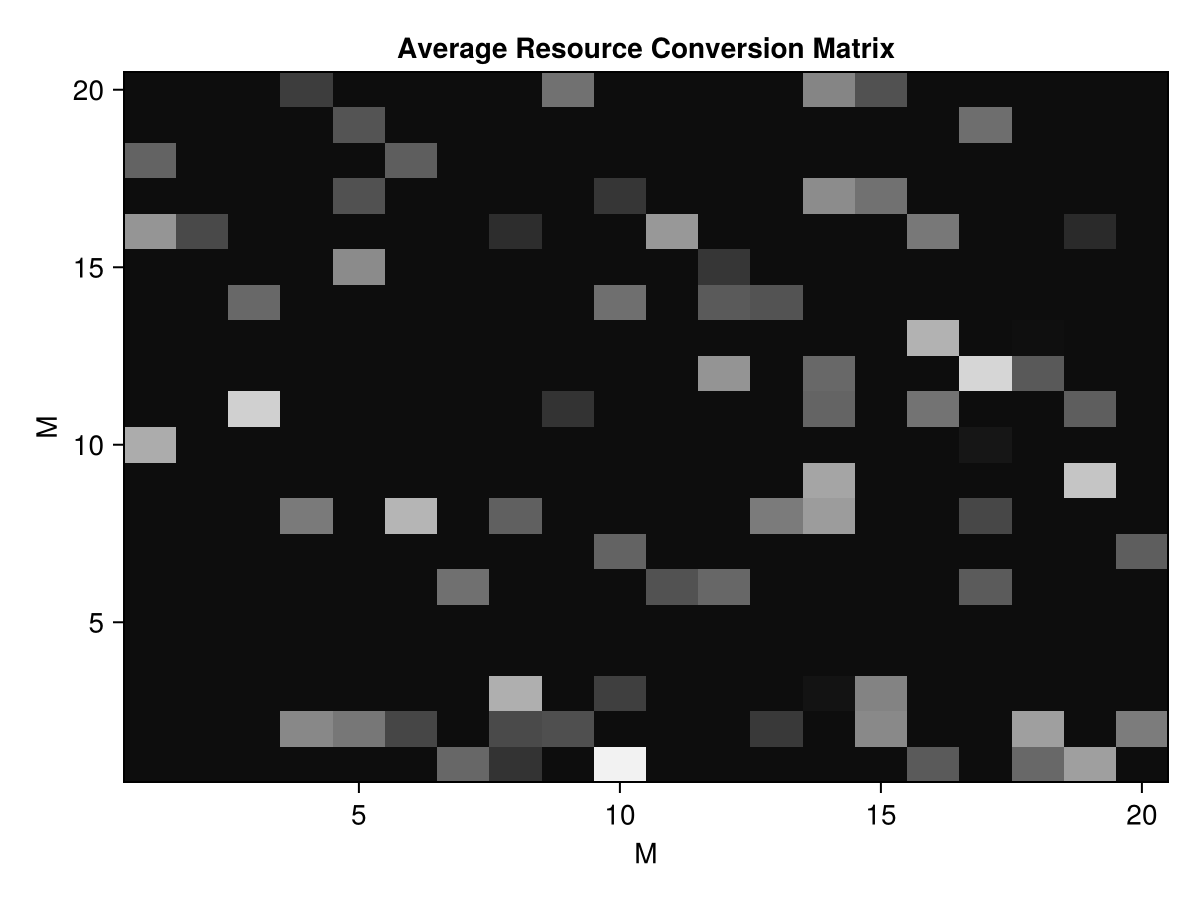

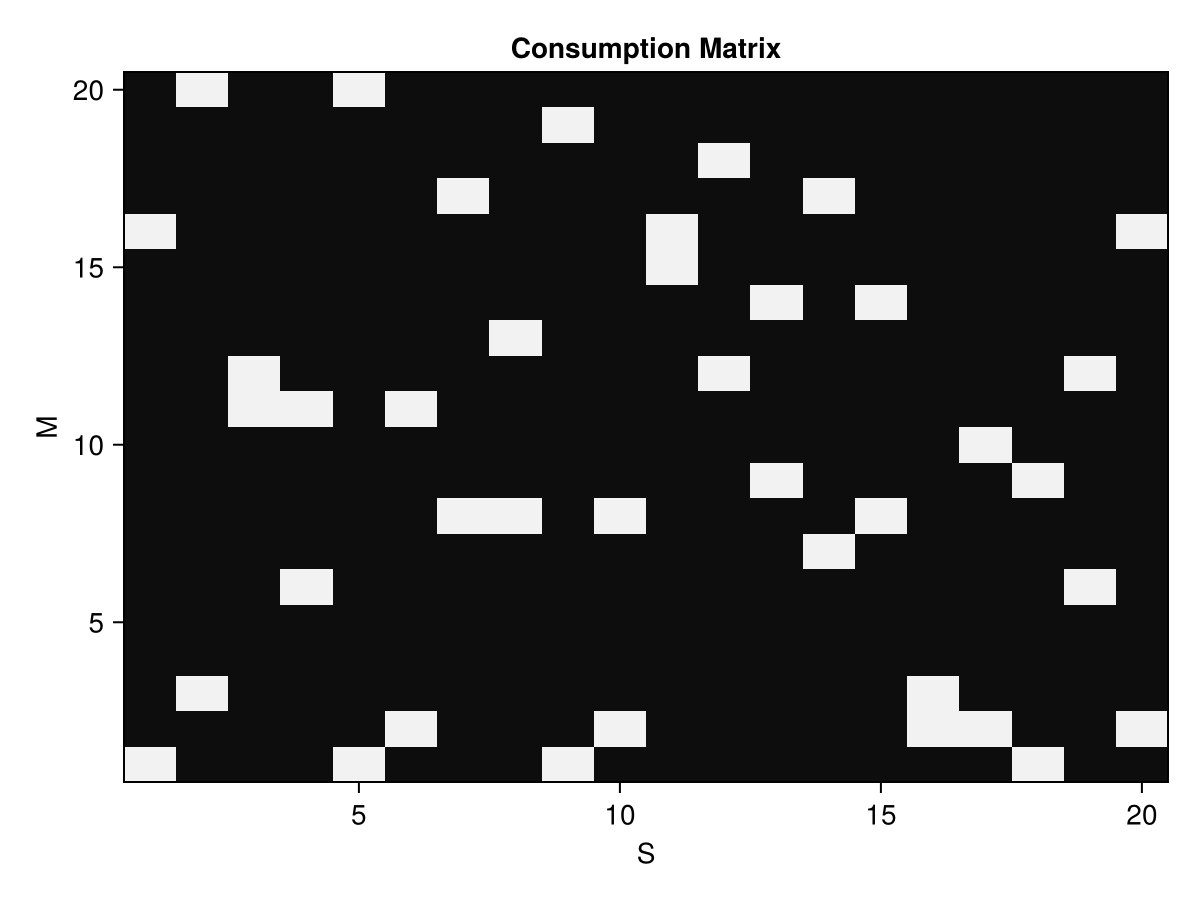

In [7]:
rsg = RSGJans1(20, 20;
    m=0.5,
    r=0.1,
    Kp=1., K=0.5,
    
    c=2.,
    l=0.8,
    sparsity_resources=0.1,
    sparsity_byproducts=0.1,
    
    DS=1e-8, DR=1.,
)

params = rsg()
D = params.D
av_D = mean(D, dims=1)
#println("shape of D: ", size(av_D))
c = params.c

# display the sampled matrices
function display_matrix(m,ttl,xlab,ylab)
    fig = Figure()
    ax = Axis(fig[1, 1], xlabel = xlab, ylabel=ylab, title=ttl)
    heatmap!(ax, m,colormap = :grays)
    fig
end

display(display_matrix(av_D[1,:,:],"Average Resource Conversion Matrix", "M", "M"))

display_matrix(c,"Consumption Matrix", "S", "M")

In [31]:
xx[xx .< 2] .= 0

perc = sum(xx)/(2*length(xx))

0.4

In [10]:
rsg = RSGStevens1(20, 20,
    0.1,
    10,
    0.1
)
@time xx = do_rg_run(rsg, 100, LinRange(0., 100., 1000);
    extinctthreshold=1e-5,
    maxresidthreshold=1e-10,
    linstabthreshold=1e-6
)
freqtable(xx)

Generating one params: 0.003080 seconds (116 allocations: 83.609 KiB)


┌ Warning: At t=45.49084646426928, dt was forced below floating point epsilon 7.105427357601002e-15, and step error estimate = 5.06248289287884e-41. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase /Users/stevenredford/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:623
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/stevenredford/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Warning: At t=21.49189380513501, dt was forced below floating point epsilon 3.552713678800501e-15, and step error estimate = 8.622263263248875e-41.

109.508940 seconds (32.14 M allocations: 6.169 GiB, 13.48% gc time, 0.33% compilation time: 100% of which was recompilation)


2-element Named Vector{Int64}
Dim1  │ 
──────┼───
-100  │  6
1     │ 94

In [11]:
mars = MarslandSampler1(20, 20
)
@time xx = do_rg_run(mars, 100, LinRange(0., 100., 1000);
    extinctthreshold=1e-8
)
freqtable(xx)

Generating one params: 0.002427 seconds (2.29 k allocations: 319.969 KiB)


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase /Users/stevenredford/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:589
┌ Warning: At t=46.0235530741883, dt was forced below floating point epsilon 7.105427357601002e-15, and step error estimate = 6.176436053221808e-40. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase /Users/stevenredford/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:623
┌ Warning: At t=287.3731252734797, dt was forced below floating point epsilon 5.684341886080802e-14, and step error estimate = 7.382550992541545e-40.

1233.418523 seconds (201.29 M allocations: 20.907 GiB, 22.30% gc time, 1.16% compilation time)


┌ Warning: At t=75.98598940658232, dt was forced below floating point epsilon 1.4210854715202004e-14, and step error estimate = 2.7041002317735305e-38. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase /Users/stevenredford/.julia/packages/SciMLBase/m1Jrs/src/integrator_interface.jl:623


3-element Named Vector{Int64}
Dim1  │ 
──────┼───
-100  │ 89
-1    │  2
1     │  9

## Now we'll try instability as a function of some stuff

In [51]:
# first overall system size
npts = 10
sizes = LinRange(5, 50, 10)
prop = fill(0., npts)

for i in 1:npts
    sz = ceil(sizes[i])
    println("size: ", sz)
    rsg = RSGJans1(sz, sz;
        m=0.5,
        r=0.1,
        Kp=1., K=0.5,

        c=2.,
        l=0.5,
        sparsity_resources=0.1,
        sparsity_byproducts=0.1,

        DS=1e-8, DR=1.,
    )
    println("params made")
    @time xx = do_rg_run(rsg, 100, LinRange(0., 100., 1000)[2:end];
        extinctthreshold=1e-5, 
        linstabthreshold=1e-10,
        maxresidthreshold=1e-10
    )
    xx[xx .< 2] .= 0
    xx[xx .> 2] .= 0
    prop[i] = sum(xx)/(2*length(xx))
    println("size: ", sz, " prop: ", prop[i])
end

size: 5.0
params made
Generating one params: 0.000838 seconds (28 allocations: 2.672 KiB)
  3.907781 seconds (3.10 M allocations: 523.991 MiB, 41.42% gc time, 30.22% compilation time: 100% of which was recompilation)
size: 5.0 prop: 0.0
size: 10.0
params made
Generating one params: 0.000233 seconds (84 allocations: 12.953 KiB)


┌ Warning: maxresid reached is 1.0235e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 1.06023e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 1.0393e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 1.03576e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 1.04066e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached

  6.964234 seconds (2.98 M allocations: 765.648 MiB, 4.08% gc time)
size: 10.0 prop: 0.0
size: 15.0
params made
Generating one params: 0.000018 seconds (174 allocations: 37.953 KiB)


┌ Warning: maxresid reached is 7.1471e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 9.36455e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 5.88913e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 3.87712e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 9.60469e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reache

2145.683802 seconds (110.43 M allocations: 12.326 GiB, 5.61% gc time)
size: 15.0 prop: 0.0
size: 20.0
params made
Generating one params: 0.001413 seconds (226 allocations: 78.797 KiB)


┌ Warning: maxresid reached is 4.23483e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 4.73464e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 9.55035e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 4.4764e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reached is 3.93758e-08 which is close to 1e-08
└ @ Main /Users/stevenredford/Dropbox/Python/SSMC/notebooks/jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_W4sZmlsZQ==.jl:40
┌ Warning: maxresid reache

InterruptException: InterruptException:

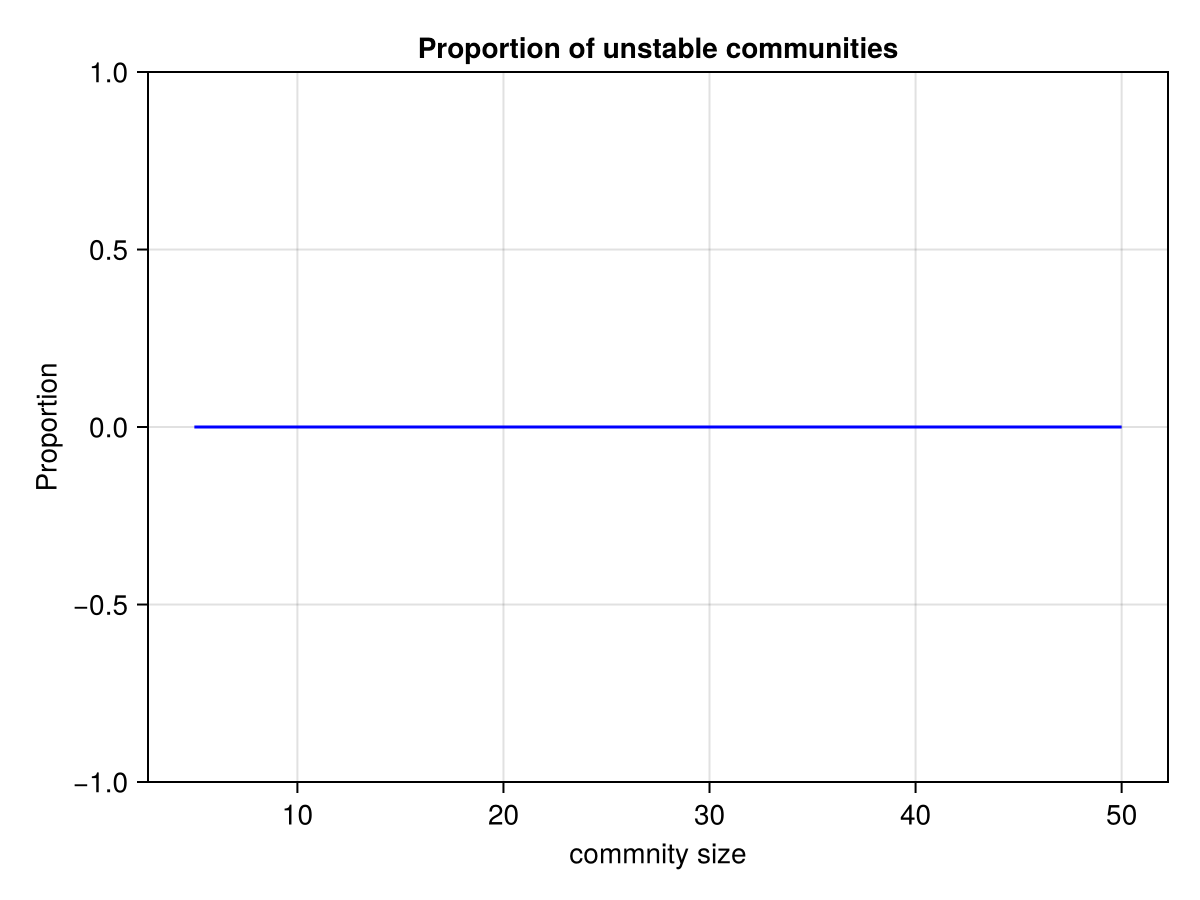

CairoMakie.Screen{IMAGE}


In [52]:
# plot prop vs sizes
fig = Figure()
ax = Axis(fig[1, 1]; title="Proportion of unstable communities", xlabel="commnity size", ylabel="Proportion")
lines!(ax, sizes, prop; color=:blue)
display(fig)

In [16]:
# now static resource size
npts = 10
sizes = LinRange(5, 50, 10)
M = 20
prop = fill(0., npts)

for i in 1:npts
    sz = ceil(sizes[i])
    #println("size: ", sz)
    rsg = RSGJans1(sz, M;
        m=0.5,
        r=0.3,
        Kp=1., K=0.5,

        c=2.,
        l=0.5,
        sparsity_resources=0.1,
        sparsity_byproducts=0.1,

        DS=1e-8, DR=1.,
    )
    #println("params made")
    @time xx = do_rg_run(rsg, 100, LinRange(0., 100., 1000)[2:end];
        extinctthreshold=1e-5, 
        linstabthreshold=1e-10,
        maxresidthreshold=1e-10
    )
    xx[xx .< 2] .= 0
    prop[i] = sum(xx)/(2*length(xx))
    #println("size: ", sz, " prop: ", prop[i])
end

Generating one params: 0.000023 seconds (74 allocations: 20.984 KiB)
  3.687128 seconds (11.45 M allocations: 3.863 GiB, 10.65% gc time, 43.21% compilation time)
Generating one params: 0.000011 seconds (124 allocations: 40.188 KiB)
  4.793598 seconds (6.39 M allocations: 3.434 GiB, 5.67% gc time)
Generating one params: 0.000010 seconds (176 allocations: 59.516 KiB)
  7.944719 seconds (8.13 M allocations: 2.893 GiB, 25.91% gc time)
Generating one params: 0.000018 seconds (226 allocations: 78.797 KiB)
  6.097170 seconds (9.75 M allocations: 2.196 GiB, 2.16% gc time)
Generating one params: 0.000018 seconds (276 allocations: 98.250 KiB)
  7.475387 seconds (11.77 M allocations: 2.199 GiB, 2.79% gc time)
Generating one params: 0.000019 seconds (326 allocations: 117.516 KiB)
  5.924995 seconds (13.52 M allocations: 1.723 GiB, 2.21% gc time)
Generating one params: 0.000013 seconds (376 allocations: 136.734 KiB)
  7.422500 seconds (22.67 M allocations: 1.972 GiB, 5.44% gc time, 22.79% compilati

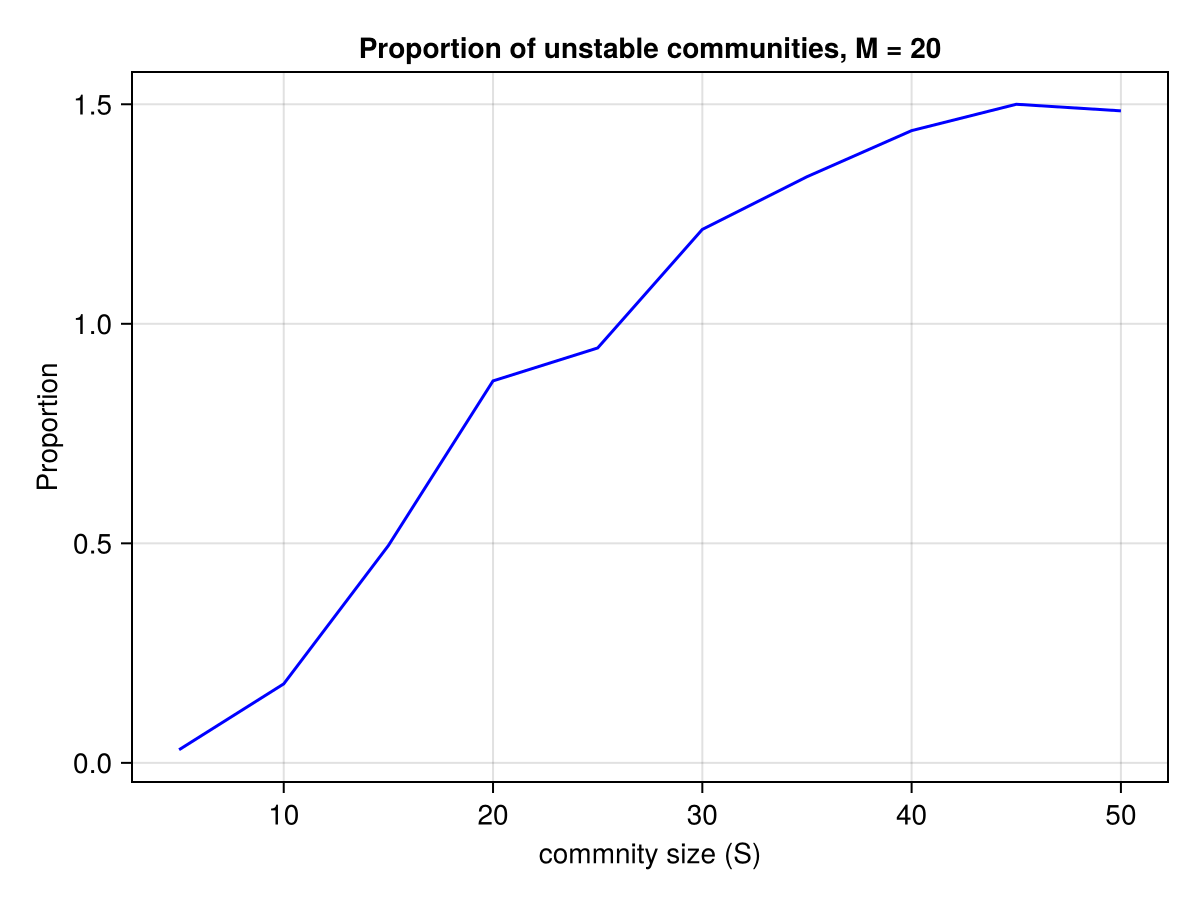

CairoMakie.Screen{IMAGE}


In [17]:
# plot prop vs sizes
fig = Figure()
ax = Axis(fig[1, 1]; title="Proportion of unstable communities, M = 20", xlabel="commnity size (S)", ylabel="Proportion")
lines!(ax, sizes, prop; color=:blue)
display(fig)

# Things I want to save for reference!

## First high instability sampler

In [213]:
rsg = RSGJans1(20, 20;
    m=0.9, # increasing m we quickly lose them!
    r=0.2,
    Kp=0.2, K=0.5,
    
    c=4.,
    l=0.5,
    sparsity_resources=0.1,
    sparsity_byproducts=0.5,
    
    DS=1e-8, DR=1.,
)
@time xx = example_do_rg_run(rsg, 100, LinRange(0., 100., 1000);
    extinctthreshold=1e-5,
    maxresidthreshold=1e-10,
    linstabthreshold=1e-6
)
freqtable(xx)

Generating one params: 0.000020 seconds (153 allocations: 92.625 KiB)
  2.313998 seconds (26.95 M allocations: 4.488 GiB)


1-element Named Vector{Int64}
Dim1  │ 
──────┼────
1     │ 100

In [106]:
@time yy = example_do_rg_run(rsg, 1, LinRange(0., 100., 1000),
    extinctthreshold=1e-5,
    maxresidthreshold=1e-10,
    linstabthreshold=1e-6,
    return_interesting=true
)
@show length(yy[2])
freqtable(yy[1])

Generating one params: 0.000012 seconds (42 allocations: 12.844 KiB)
  0.012593 seconds (48.18 k allocations: 35.942 MiB)
length(yy[2]) = 0


1-element Named Vector{Int64}
Dim1  │ 
──────┼──
1     │ 1

In [88]:
ps = yy[2][1];

# Running a single system

In [40]:
ps = rsg();

## No space solver

In [89]:
u0 = make_u0_smart(ps; u0=:onlyN)
ssp = make_mmicrm_ss_problem(ps, u0)
@time sss = solve(ssp, DynamicSS(QNDF()); reltol=1e-9);
maximum(abs, sss.resid)

  0.002248 seconds (1.30 k allocations: 262.016 KiB)


8.89638261349542e-9

maximum(abs, (s.u[end])[1:(get_Ns(ps))[1]]) = 6.0


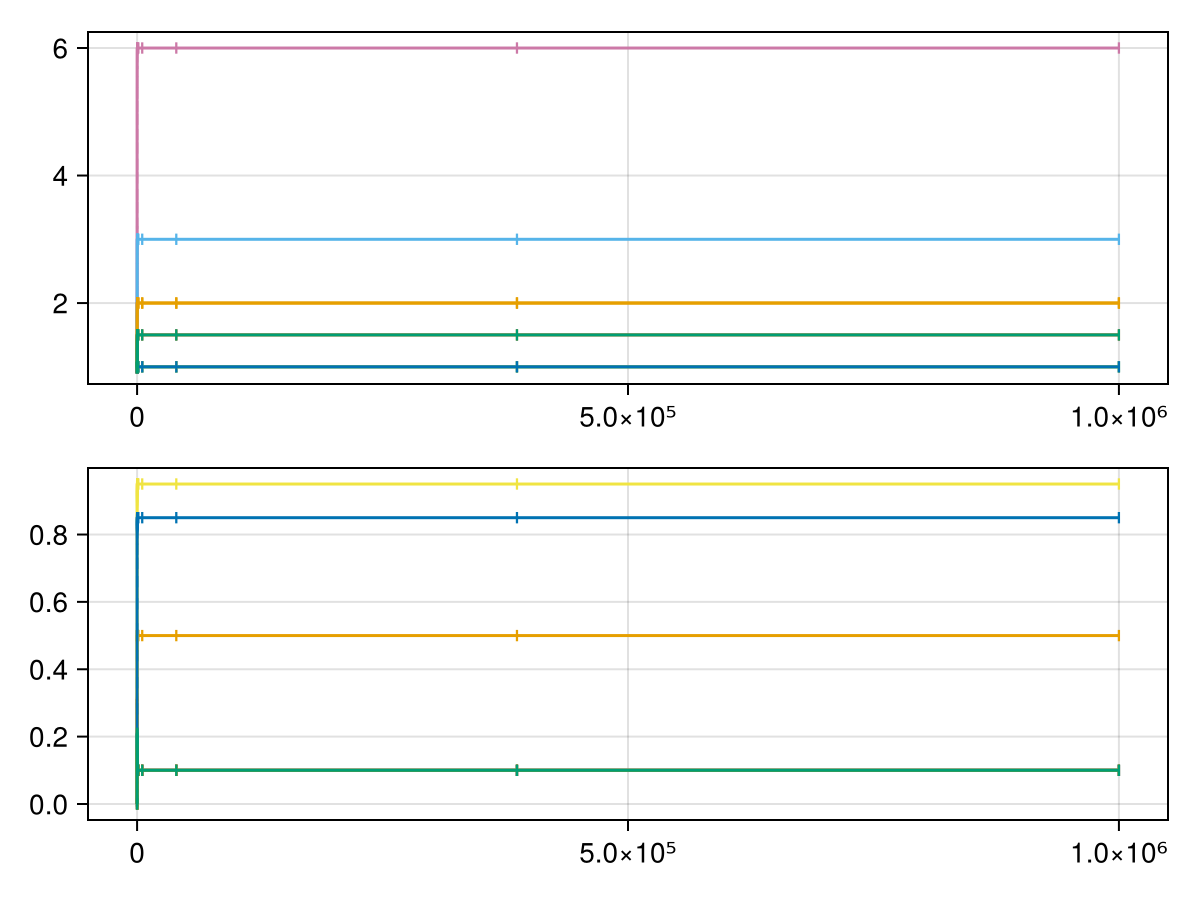

In [90]:
u0 = make_u0_smart(ps; u0=:onlyN);
p = make_mmicrm_problem(ps, u0, 1000000);

s = solve(p)
@show maximum(abs, s.u[end][1:get_Ns(ps)[1]])

f = plot_mmicrm_sol(s)
# display(GLMakie.Screen(), f)
f

## Spatial stuff

In [91]:
nssol = s.u[end];
xx = uninplace(mmicrmfunc!)(nssol, ps)
maxresid = maximum(abs, xx)
@show maxresid;

maxresid = 3.3306690738754696e-16


### Linear stability

In [92]:
ks = LinRange(0., 100., 1000)

lamfunc = linstab_make_k_func(ps, nssol)
lambdas = lamfunc.(ks);

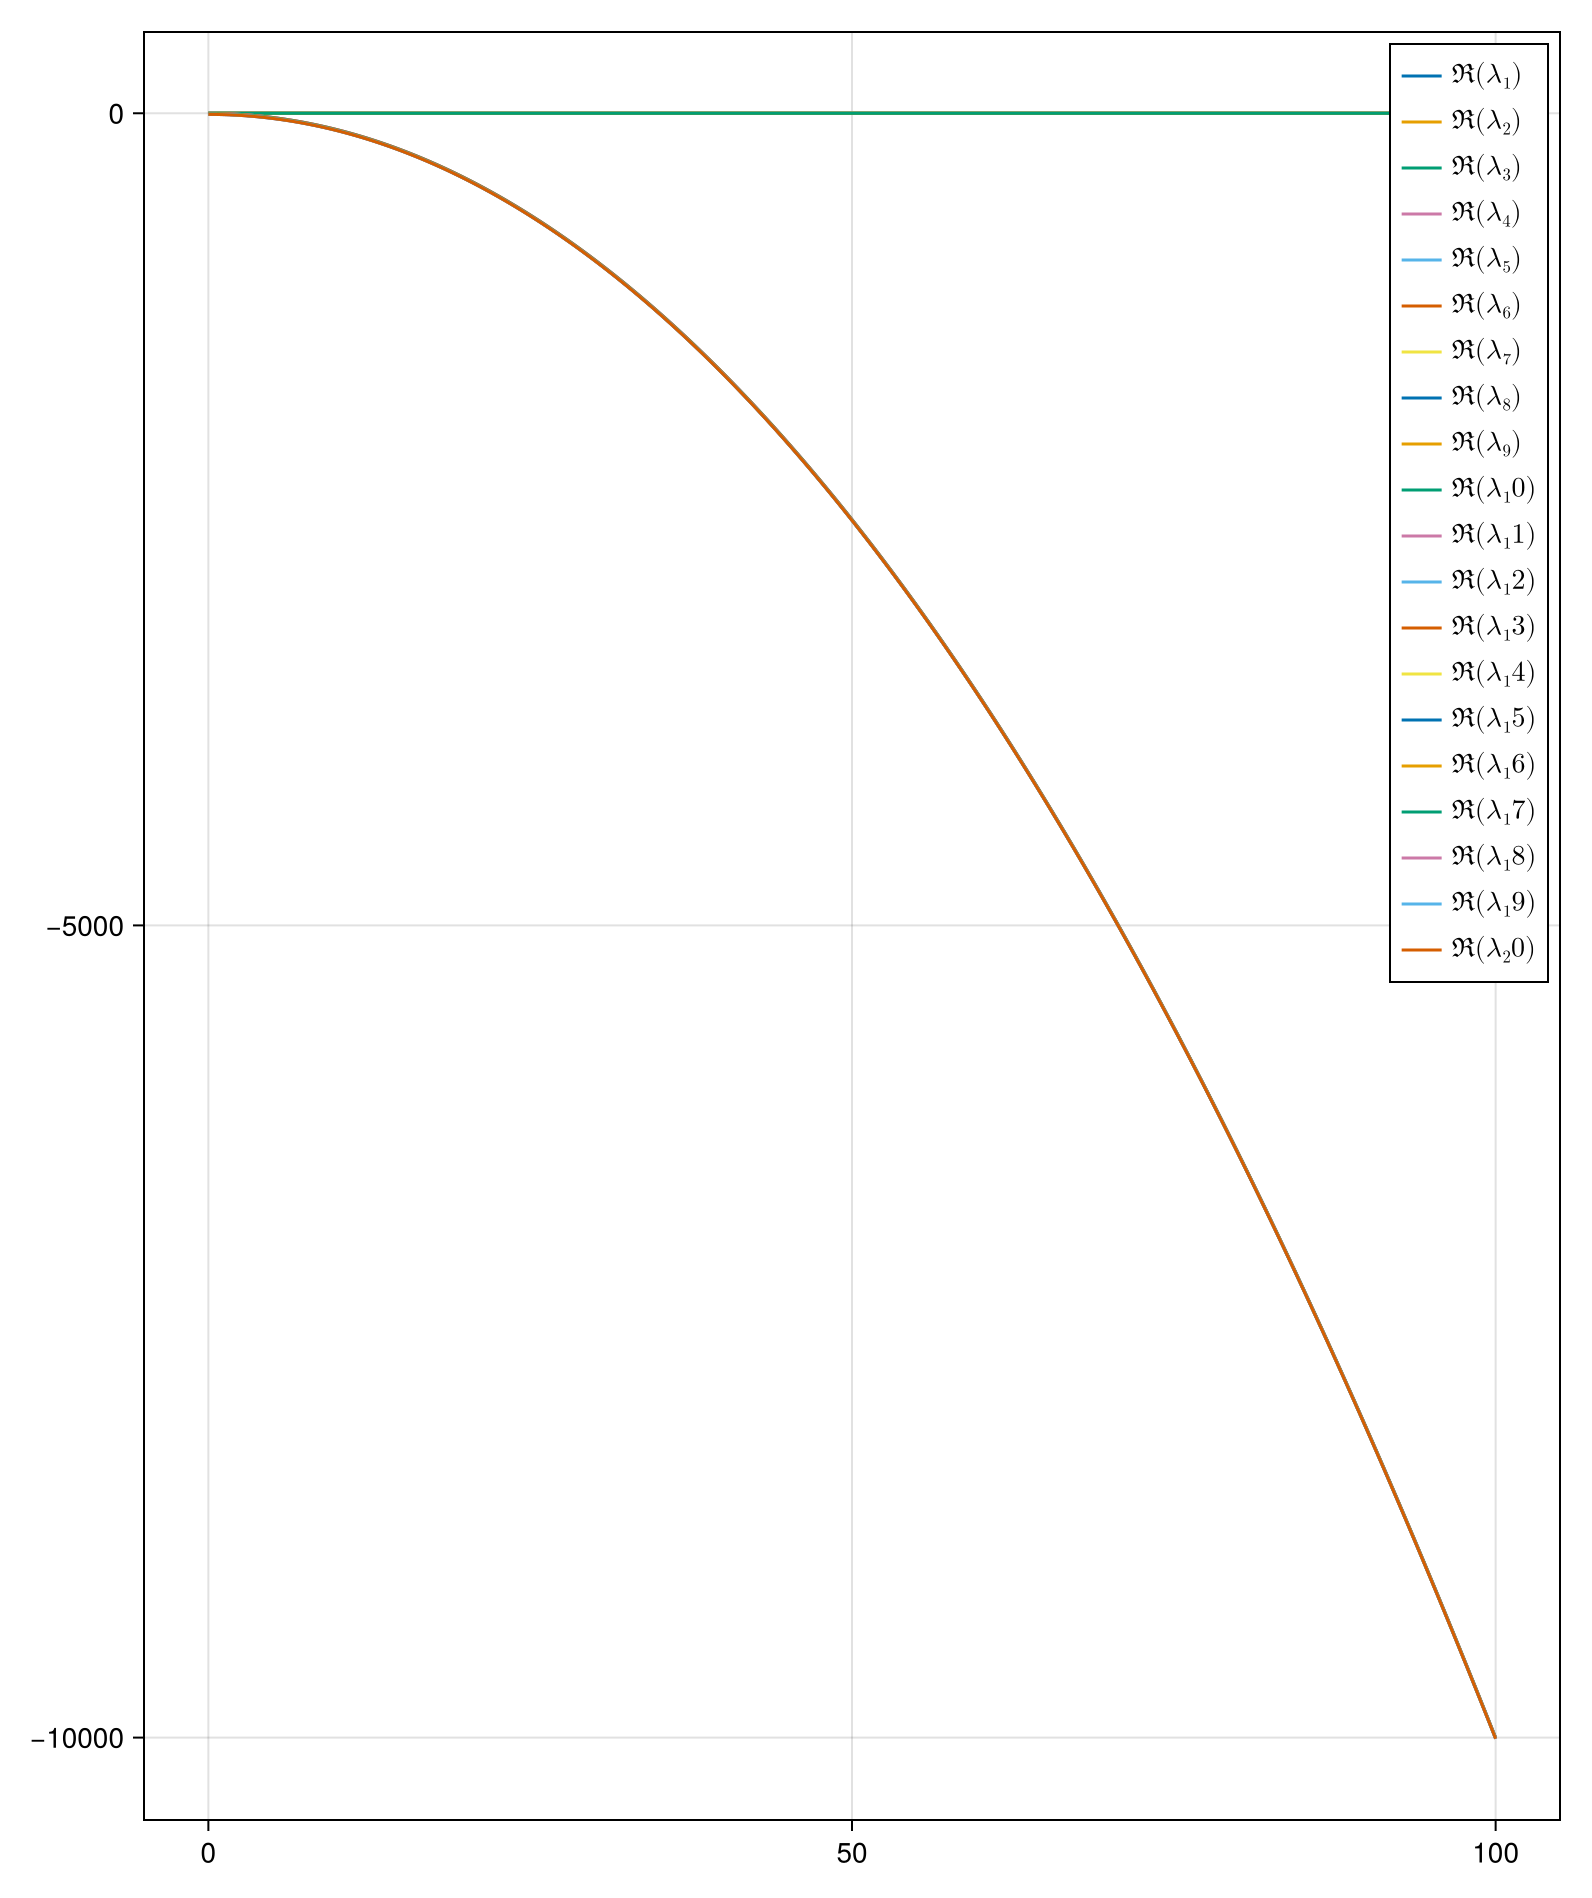

In [93]:
faa = plot_linstab_lambdas(ks, lambdas)
display(GLMakie.Screen(), faa.figure)
faa

### 1D spatial

In [89]:
ssize = (1000,)
dx = 0.01

# baseu0 = nssol
baseu0 = make_u0_smart(ps; u0=:onlyN)
su0 = expand_u0_to_size(ssize, baseu0)
su0 = perturb_u0_uniform_prop(get_Ns(ps)..., su0, 0.1, 0.1)


spaceps = change_bsmmicrmparams(ps; space=make_cartesianspace_smart(1;
    dx,
    bcs=Periodic()),
    usenthreads=nthreads()
)
@show spaceps.usenthreads spaceps.mmicrm_params.usenthreads

sp = make_smmicrm_problem(spaceps, su0, 100000);

spaceps.usenthreads = 18
spaceps.mmicrm_params.usenthreads = nothing


In [90]:
@time sps = solve(sp, QNDF());
print_spatial_solution_stats(sps)

 20.937264 seconds (128.32 k allocations: 5.782 GiB, 2.01% gc time)
Success
nf is 880
solution has 150 saved states
max resid is 2.00273e-11


┌ Warning: reaching negative values, minimum is -3.32617e-06
└ @ SSMCMain.ModifiedMiCRM ~/UCLOneDrive/Projects/SSMC/src/SSMCMain/src/ModifiedMiCRM/util.jl:10


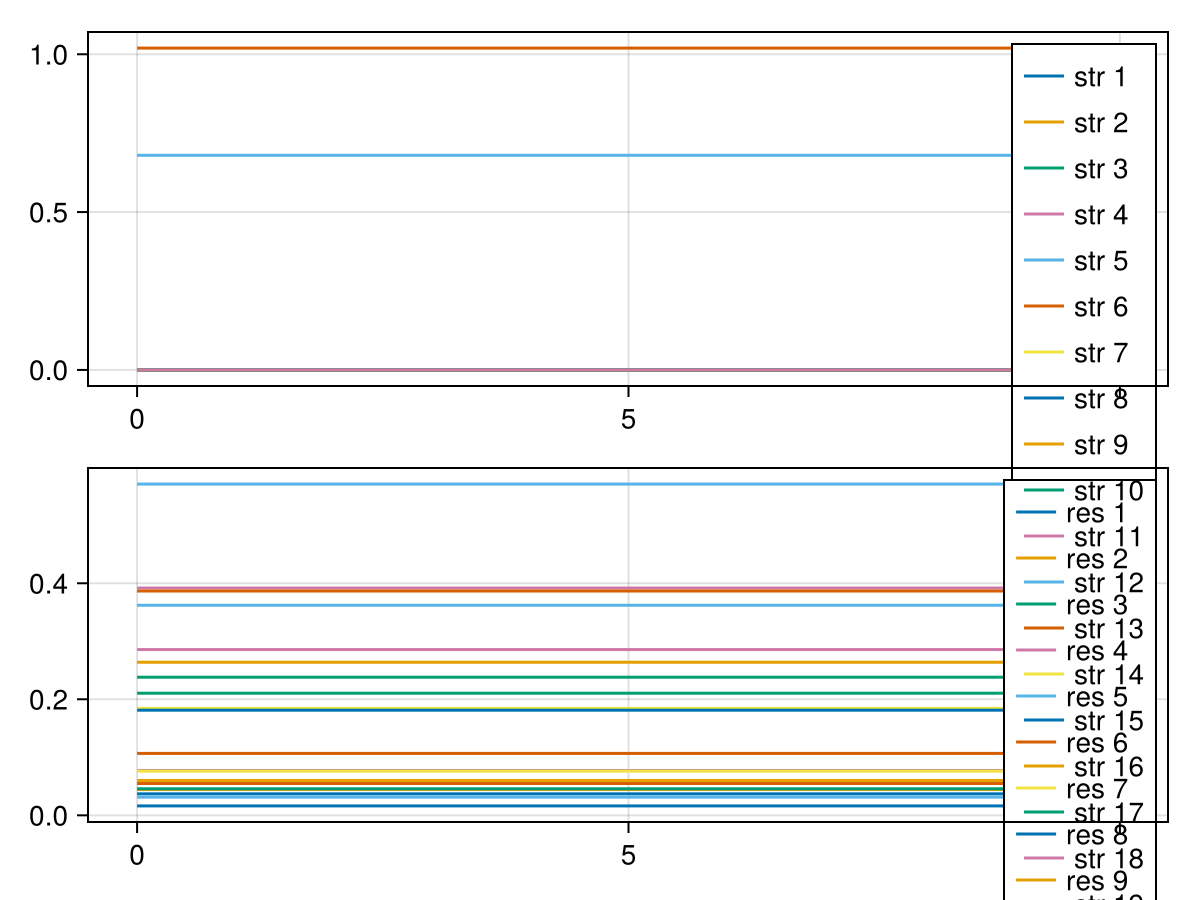

In [105]:
plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[150])

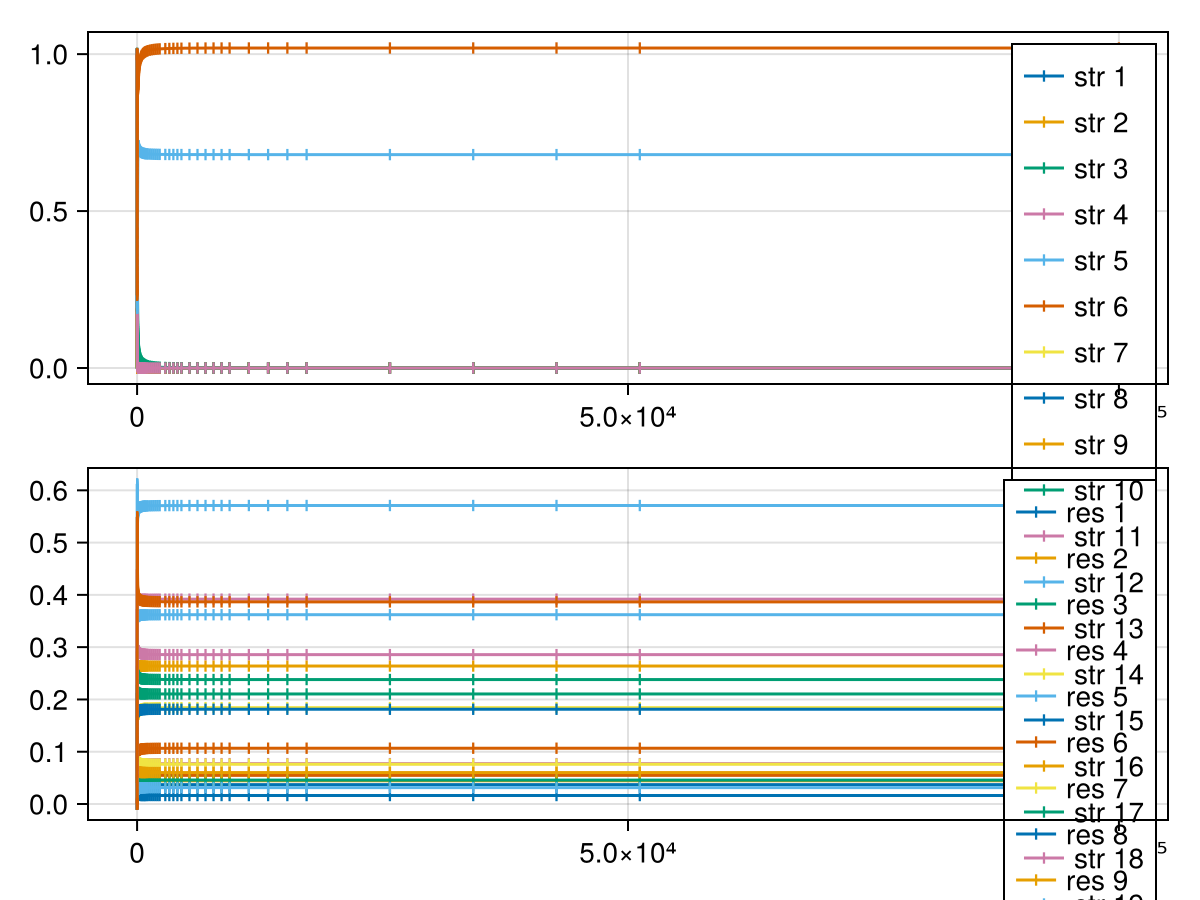

In [92]:
plot_smmicrm_sol_avgs(sps)

# Running Stevens generator

In [44]:
rsg = RSGStevens1(20, 20, 1., 0.35);
@time xx = do_rg_run(rsg, 1000, LinRange(0., 40., 10000);
    extinctthreshold=1e-5
)
freqtable(xx)

Generating one params: 0.033824 seconds (40.34 k allocations: 8.685 MiB)
maxresid reached is 0.000011 > 0.000010maxresid reached is 0.000011 > 0.000010maxresid reached is 0.000042 > 0.000010maxresid reached is 0.000995 > 0.000010

┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/7BHQj/src/integrator_interface.jl:589


487.655912 seconds (428.92 M allocations: 371.603 GiB, 6.12% gc time, 0.00% compilation time)


5-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │   5
-100  │   1
-1    │   4
1     │ 979
2     │  11

# Bigger runs

In [114]:
bigrsg = RSGJans1(50, 50;
    m=1.,
    r=1.,
    Kp=0.1, K=10.0,
    
    c=(2., 1.),
    l=0.2,
    sparsity_resources=0.1,
    sparsity_byproducts=0.5,
    
    DS=1e-8, DR=1.,
)

@time xx = do_rg_run(rsgj, 1000, LinRange(0., 1000., 1000);
    extinctthreshold=1e-5
)

jldsave(datadir("randomsystems/prelim", randname()*".jld2");
    rsg=bigrsg,
    output=xx
)

freqtable(xx)

Generating one params: 0.000501 seconds (865 allocations: 1.265 MiB)
451.332197 seconds (3.80 G allocations: 174.887 GiB, 4.30% gc time, 0.00% compilation time)


3-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │  14
1     │ 985
2     │   1

# Looking/comparing saved data

In [128]:
f = jldopen("../data/randomsystems/prelim/Proactive-Fuchsia-Mongoose.jld2")
xx = f["output"]
frsg = f["rsg"]
freqtable(xx)

3-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │   9
1     │ 987
2     │   4

In [134]:
f = jldopen("../data/randomsystems/prelim/Likable-Periwinkle-Viper.jld2")
xx = f["output"]
frsg = f["rsg"]
freqtable(xx)

3-element Named Vector{Int64}
Dim1  │ 
──────┼────
-101  │   2
1     │ 994
2     │   4

# Extras

In [189]:
GC.gc()
empty!(Out)
GC.gc()